# Advection-Diffusion 1D: Gaussian step

A 1D advection-diffusion problem with a gaussian step as initial condition.

## Import Modules

**Standard**

In [1]:
import time
import numpy as np
import math

**High performance computing**

In [2]:
from numba import vectorize, jit

**Plotting**

In [3]:
import gr
from gr import pygr
gr.inline('svg')

**Lattice boltzmann solver**

In [4]:
import ragnarok

## Plotting function

In [7]:
def plot(variable,t):
    pygr.plot(variable,ylim=(0.9,1.7),title='T = {}'.format(t),accelerate=True)

## Settings

**Simulation parameters**

In [8]:
N = 800 # Number of lattice
u = 0.1 # Lattice speed
nu = 5e-8 # Viscosity
T_max = 4000 # Maximum number of time steps

**Postprocessing parameters**

In [9]:
plot_step = 10

## Solver

Initialze the advection diffusion 1D solver

In [10]:
solver = ragnarok.AdvectionDiffusion1D(u=u, nu=nu, Nx=N)

Reference parameters:

In [11]:
# Get parameters
u   = solver.u
Nx  = solver.Nx
x = solver.x

## Initial conditions

Define the initial condition:

\begin{equation}
    $\rho_0 (0\le x \le N) = 1 + \frac{1}{2}\exp \left\{ -5000\left( \frac{x}{N} - \frac{1}{2} \right)^2\right\}$
\end{equation}

** Step gaussian profile for density**

In [10]:
rho0 = 1 + 0.5*np.exp(-5000*(np.arange(N)/float(N) - 0.25)**2 )
solver.rho = rho0

**Correction initial population**

Correct equilibrium population:   

In [11]:
solver.correct_feq_python()

Initialize population:    

In [12]:
solver.f = solver.feq.copy()

Correct macroscopic properties:    

In [13]:
solver.correct_macroscopic_python()

** Plot initial condition **

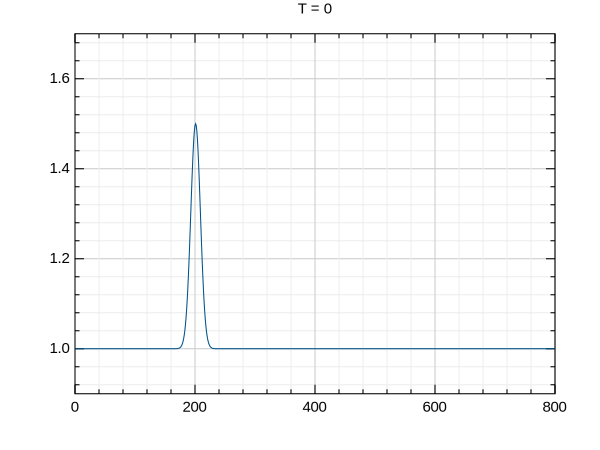

In [14]:
plot(solver.rho,0)

## Time stepping

**Simulation Algorithm**:
 1. `stream`: Streaming / advection step: $f'_i(x) \leftarrow f^n_i(x-c_i)$
 2. `correct_macroscopic`: Correct the macroscopic parameters: ${\rho',u_x',u_y',P'} = f(f',c)$
 3. `correct_feq`: Correct the equilbirum population: $f_{eq}' = f(\rho',u_x',u_y',P')$
 4. `relax`: Relaxation / collision step: $f^{n+1}_i(x) \leftarrow f'_i  + \alpha\beta \left[f'^{eq}_i(x,t) - f'_i(x,t)\right]$

$x=y$

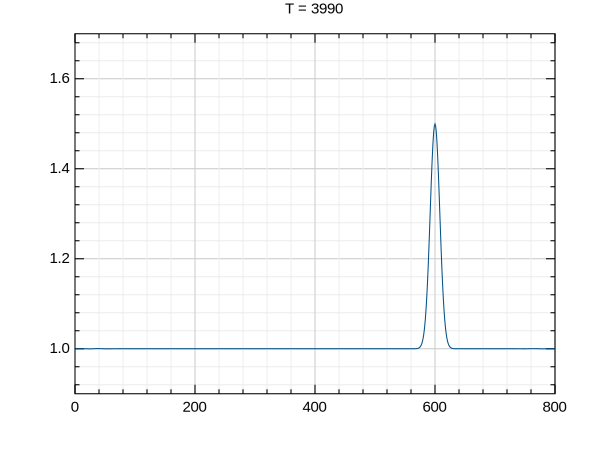

Total time: 4.10423 sec for 4000 steps, 1.02606 ms/step


In [15]:
for t in range(T_max):
    if t==1: # skip JIT overhead
        startTime = time.time()
    
    # Print time
    if (t % (T_max // 4))  == 0: print('T = %d' % t)

    # Plot
    if t % plot_step == 0:
        plot(solver.rho,t)
   
    # Step 1: Streaming / advection step: f'_i(x) <- f^n_i(x-c_i)
    solver.stream_python()
    
    # Step 2: Correct the macroscopic parameters: {rho',ux',uy',P'} = f(f',c)
    solver.correct_macroscopic_python()
    
    # Step 3: Correct the equilbirum population: f_eq' = f(rho',ux',uy',P')
    solver.correct_feq_python()
    
    # Step 4: Relaxation / collision step: f^{n+1}_i(x) <- f'_i + \alpha\beta [f^{eq}'_i(x,t) - f'_i(x,t)]
    solver.relax_python()
    
    if solver.rho.min() <= 0.:
        print('Density is negative!')
        break

# Done
duration = time.time()-startTime
print('Total time: {:3g} sec for {:d} steps, {:3g} ms/step'.format(duration, T_max, duration/T_max*1000))        